cd OneDrive/Bureaublad/ARC/deep-multimodal-learning/mvae/Scripts/activate.bat

In [1]:
import torch
from functions import get_loader, plot_histories, plot_history
from functions_cae import train_cae, validate_cae, DeepCAE, SimpleCAE, SimpleCAE_Dropout, visualize_latent_space, visualize_reconstruction, get_latent_dataset
import torch.nn as nn
from functions_mlp import rawMLP, train_mlp, validate_mlp, caeMLP
import matplotlib.pyplot as plt

In [2]:
##### CONFIG
NUM_EPOCHS = 5
LR_RATE = 1e-3
BATCH_SIZE = 4
WEIGHT_DECAY = 1e-5

DEVICE = ""
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using GPU...")
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available. Using CPU...")

BASE_PATH = 'C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/data_v2'

# Define the tool names and actions
TOOL_NAMES = ['hook', 'ruler', 'spatula', 'sshot']
ACTIONS = ['left_to_right', 'pull', 'push', 'right_to_left']

# All available object names
train_objects = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
            '5_blackCoinbag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg','9_pumpkinToy',
            '10_tomatoCan', '11_boxMilk']

val_objects = ['12_containerNuts', '13_cornCob', '14_yellowFruitToy',
            '15_bottleNailPolisher']

test_objects =['16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

CUDA is available. Using GPU...


In [3]:
train_loader = get_loader(BASE_PATH, train_objects, TOOL_NAMES, ACTIONS, "color", "training", batch_size=BATCH_SIZE)
val_loader = get_loader(BASE_PATH, val_objects, TOOL_NAMES, ACTIONS, "color", "validation", batch_size=BATCH_SIZE)
test_loader = get_loader(BASE_PATH, test_objects, TOOL_NAMES, ACTIONS, "color", "testing", batch_size=BATCH_SIZE)

In [4]:
# cae_lossfunction = nn.MSELoss()
cae_lossfunction = nn.BCELoss()

# Training loop
#cae = SimpleCAE().to(DEVICE)
#cae = SimpleCAE_Dropout().to(DEVICE)
cae = DeepCAE().to(DEVICE)
cae_optimizer_adam = torch.optim.Adam(cae.parameters(), lr=LR_RATE)
cae_optimizer_sgd = torch.optim.SGD(cae.parameters(), lr=LR_RATE, momentum=0.9)
cae_optimizer_adamw = torch.optim.AdamW(cae.parameters(), lr=LR_RATE, weight_decay=1e-2)

trained_cae, cae_batch_loss_history, cae_epoch_loss_history = train_cae(cae, train_loader, cae_lossfunction, cae_optimizer_adam, NUM_EPOCHS, True, DEVICE)
avg_val_loss, cae_validation_loss_history = validate_cae(trained_cae, test_loader, cae_lossfunction, DEVICE)

KeyboardInterrupt: 

In [13]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights/deepcae_ne5_b4.pth"
torch.save(trained_cae.state_dict(), model_path)

In [5]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights/deepcae_ne5_b4.pth"
trained_cae = DeepCAE()
trained_cae.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
# Config MLP
mlp_lossfunction = nn.CrossEntropyLoss()  # Loss function
output_dim = 4 
NUM_EPOCHS = 5
LR_RATE = 1e-3

# Extract features from the train and validation sets
train_dataset = get_latent_dataset(trained_cae, val_loader)
val_dataset = get_latent_dataset(trained_cae, test_loader)

# Create DataLoaders for the extracted features
mlp_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mlp_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize
input_dim = train_dataset[:][0].size(1)
mlp = caeMLP(input_dim, output_dim).to(DEVICE)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=LR_RATE)

# Train the model
trained_mlp = train_mlp(mlp, mlp_lossfunction, mlp_optimizer, mlp_train_loader, NUM_EPOCHS, DEVICE)

# Validate the model
validate_mlp(mlp, mlp_lossfunction, mlp_val_loader, DEVICE)

Epoch [1/5], Train Loss: 1.8819, Train Acc: 0.5312, Train Precision: 0.5308, Train Recall: 0.5312, Train F1: 0.5309
Epoch [2/5], Train Loss: 0.5758, Train Acc: 0.7781, Train Precision: 0.7792, Train Recall: 0.7781, Train F1: 0.7783
Epoch [3/5], Train Loss: 0.4015, Train Acc: 0.8391, Train Precision: 0.8399, Train Recall: 0.8391, Train F1: 0.8391
Epoch [4/5], Train Loss: 0.3339, Train Acc: 0.8656, Train Precision: 0.8655, Train Recall: 0.8656, Train F1: 0.8655
Epoch [5/5], Train Loss: 0.3313, Train Acc: 0.8641, Train Precision: 0.8645, Train Recall: 0.8641, Train F1: 0.8639
Val Loss: 0.0276, Val Acc: 0.9734, Val Precision: 0.9741, Val Recall: 0.9734, Val F1: 0.9732
Confusion Matrix:
 [[147   5   7   1]
 [  1 158   0   1]
 [  0   1 159   0]
 [  0   1   0 159]]


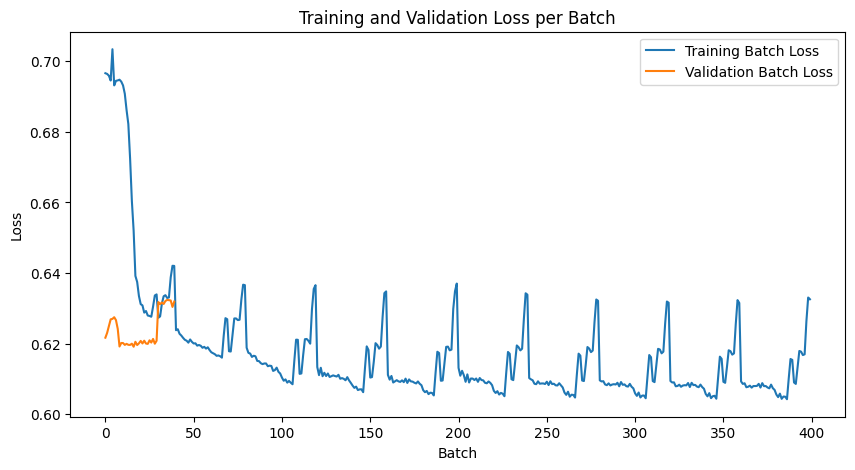

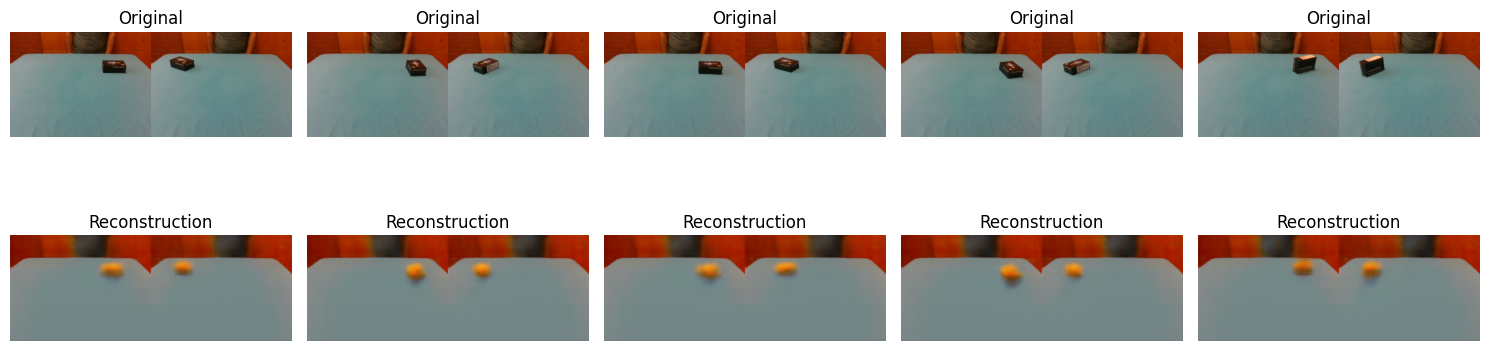

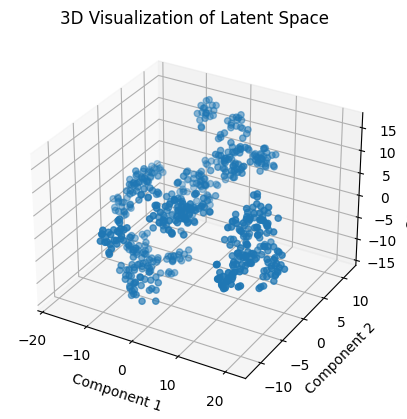

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


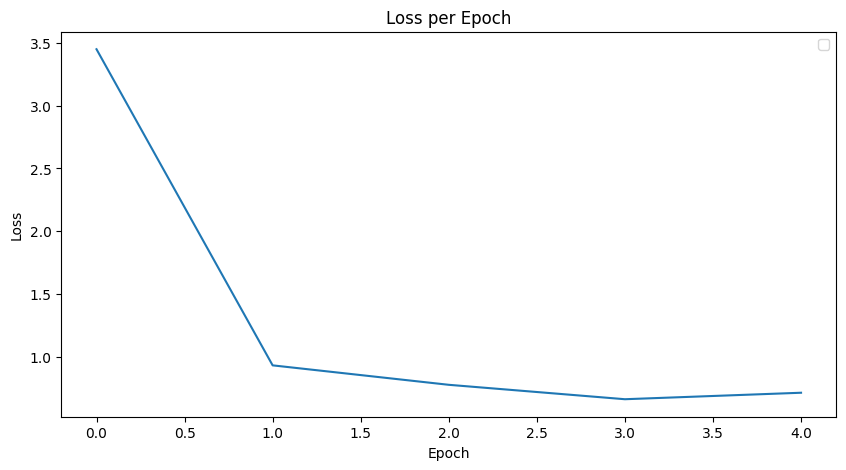

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


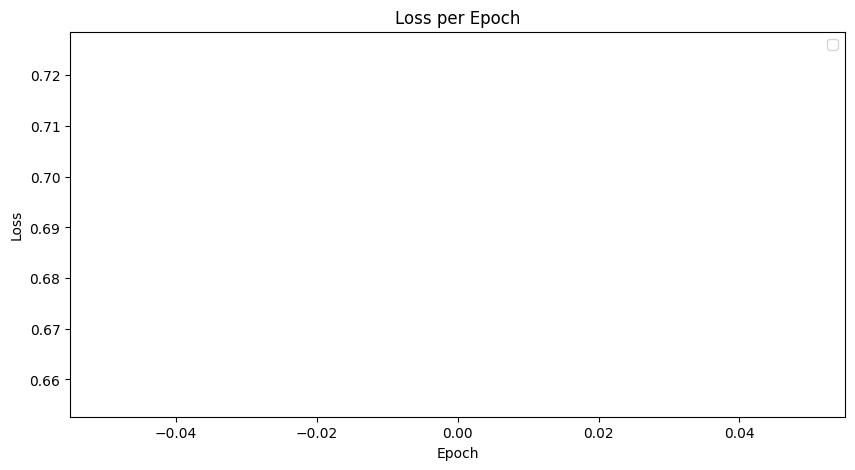

In [9]:
plot_histories(cae_batch_loss_history, cae_validation_loss_history)
visualize_reconstruction(trained_cae, test_loader, num_samples=5)
visualize_latent_space(trained_cae, test_loader, n_components=3)
plot_history(mlp_epoch_avg_losses)
plot_history(mlp_epoch_accuracy)

In [ ]:
"early_stopping" after some epochs no improvements.
"superimpose"